<a href="https://colab.research.google.com/github/ForestTiger-GH/COTRA/blob/main/COTRA%20v.6.2_Matrix%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Прогноз фьючерсных цен**

На основе регрессионного анализа: статистики Commitments of Traders и агрегированной матрицы будущих цен

# Подготовка данных

### Импорт библиотек

In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import urllib.request
from zipfile import ZipFile
from io import BytesIO
from sklearn import linear_model 

import copy

### Загрузка архивов

In [3]:
# Disaggregated Futures Only Reports:
Fdisagg_2006_2016 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_hist_2006_2016.zip').read())).open('F_Disagg06_16.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2010 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2010.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2011 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2011.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2012 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2012.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2013 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2013.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2014 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2014.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2015 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2015.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2016 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2016.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2017 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2017.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2018 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2018.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2019 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2019.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2020 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2020.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Fdisagg_2021 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_disagg_txt_2021.zip').read())).open('f_year.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})

# Traders in Financial Futures ; Futures Only Reports:
Ffin_2006_2016 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fin_fut_txt_2006_2016.zip').read())).open('F_TFF_2006_2016.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2010 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2010.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2011 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2011.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2012 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2012.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2013 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2013.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2014 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2014.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2015 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2015.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2016 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2016.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2017 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2017.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2018 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2018.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2019 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2019.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2020 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2020.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})
Ffin_2021 = pd.read_csv(ZipFile(BytesIO(urllib.request.urlopen('https://www.cftc.gov/files/dea/history/fut_fin_txt_2021.zip').read())).open('FinFutYY.txt'), sep=',', error_bad_lines=False, decimal='.', encoding='gbk', skiprows=0).rename(columns={'Report_Date_as_MM_DD_YYYY': 'Report_Date_as_YYYY-MM-DD'})

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,120,121,125,133,134,135,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,186) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (133,145,146,147,148,149,159,160) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (133,147,148,149,150,159,160) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (147,148,149,150,159,160) 

# Ввод параметров

Download_Stock_Prices (ticker, yf_ticker, number_future_weeks, target_price_count, skip_count_less)

*   ticker  - пользовательское название финансового инструмента
*   yf_ticker - биржевой код финансового инструмента
*   number_future_weeks - количество будущих недель для построения матрицы (ширина)
*   target_price_count - целевая цена, значения выше которой будут учитываться
*   skip_count_less - отсечение собранного количества целевых цен, если их меньше

cot_ticker - наименование финансового инструмента в статистике СОТ

In [95]:
# Загрузка словаря для корректировки ошибочных наименований (лишние пробелы и пр.)
corrections = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Corrections.txt', sep='\t', error_bad_lines=False, skiprows=0)
check = np.array(corrections).tolist()

# Файл со списком дат публикаций отчетов СОТ
dates = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Dates_20110104_20210323.txt', parse_dates=True)

# Список инструментов
instruments = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Instruments.csv', sep=';', error_bad_lines=False, skiprows=0).set_index(['Index'])

# Выбор инструмента по номеру из списка
set_index_of_instrument = 24

# Параметры построения матрицы цен
number_future_weeks = 26
target_price_count = 0.01
skip_count_less = 0

# Параметры для обзора крайних значений
last_weeks = 156


# Параметры для бэктеста

# DEF
desired_price = 0.008
trust_level = 10

#CYCLE
desired_price_from = 0.002
desired_price_to = 0.030
desired_price_step = 0.002
desired_price_range = np.arange(desired_price_from, desired_price_to, desired_price_step)
trust_level_range = np.arange(1, number_future_weeks+1, 1)

ticker = instruments['Ticker'][set_index_of_instrument]
yf_ticker = instruments['Yf_ticker'][set_index_of_instrument]
cot_ticker = instruments['Cot_ticker'][set_index_of_instrument]

### Список инструментов

In [46]:
instruments

,Type,Ticker,Yf_ticker,Cot_ticker
Index,,,,
1,Commodities,Aluminum,ALI=F,ALUMINUM MW US TR PLATTS - COMMODITY EXCHANGE ...
2,Commodities,Coffee,KC=F,COFFEE C - ICE FUTURES U.S.
3,Commodities,Copper,HG=F,COPPER-GRADE #1 - COMMODITY EXCHANGE INC.
4,Commodities,Corn,ZC=F,CORN - CHICAGO BOARD OF TRADE
5,Commodities,CrudeOil_LightSweetWTI,CL=F,"CRUDE OIL, LIGHT SWEET-WTI - ICE FUTURES EUROPE"
6,Commodities,Gold,GC=F,GOLD - COMMODITY EXCHANGE INC.
7,Commodities,Palladium,PA=F,PALLADIUM - NEW YORK MERCANTILE EXCHANGE
8,Commodities,Platinum,PL=F,PLATINUM - NEW YORK MERCANTILE EXCHANGE
9,Commodities,Silver,SI=F,SILVER - COMMODITY EXCHANGE INC.


Не работают, из-за расхождения дат:

*   Aluminum (недавний)
*   Russian Ruble (были неторговые дни)
*   Index Russell 2000 (недавний)




# Commitments of Traders

### Обработка

Формируется товарная и финансовая модель для всех инструментов: 

обрезается, фильтруется, объединяется по списку дат

Disaggregated Futures Only Reports:

In [47]:
# Объединение в один df
Fdisagg_2010_now = []
Fdisagg_2010_now = Fdisagg_2010.append(Fdisagg_2011).append(Fdisagg_2012).append(Fdisagg_2013).append(Fdisagg_2014).append(Fdisagg_2015).append(Fdisagg_2016).append(Fdisagg_2017).append(Fdisagg_2018).append(Fdisagg_2019).append(Fdisagg_2020).append(Fdisagg_2021)

# Фильтр лишних колонок
Fdisagg_2010_now = Fdisagg_2010_now.iloc[:, 0:23].drop(Fdisagg_2010_now.columns[[1, 3, 4, 5, 6]], axis=1)

# Замена по списку
for i in range(len(check)):
    Fdisagg_2010_now['Market_and_Exchange_Names'].replace(to_replace = check[i][0], value = check[i][1], inplace = True)

# Переименование столбца дат
Fdisagg_2010_now.rename(columns={'Report_Date_as_YYYY-MM-DD' : 'Date'}, inplace=True)

# Объединение на основе списка дат
Fdisagg_2010_now = dates.merge(Fdisagg_2010_now, on='Date')

Traders in Financial Futures ; Futures Only Reports:

In [48]:
# Объединение в один df
Ffin_2010_now = []
Ffin_2010_now = Ffin_2010.append(Ffin_2011).append(Ffin_2012).append(Ffin_2013).append(Ffin_2014).append(Ffin_2015).append(Ffin_2016).append(Ffin_2017).append(Ffin_2018).append(Ffin_2019).append(Ffin_2020).append(Ffin_2021)

# Фильтр лишних колонок
Ffin_2010_now = Ffin_2010_now.iloc[:, 0:24].drop(Ffin_2010_now.columns[[1, 3, 4, 5, 6]], axis=1)

# Замена по списку
for i in range(len(check)):
    Ffin_2010_now['Market_and_Exchange_Names'].replace(to_replace = check[i][0], value = check[i][1], inplace = True)

# Переименование столбца дат
Ffin_2010_now.rename(columns={'Report_Date_as_YYYY-MM-DD' : 'Date'}, inplace=True)

# Объединение на основе списка дат
Ffin_2010_now = dates.merge(Ffin_2010_now, on='Date')

# Фьючерсные котировки

Класс для загрузки и обработки котировок фьючерсов под список дат отчетов СОТ

In [49]:
class Download_Stock_Prices(object):

# Матрицы рассчитываются на основе номеров столбцов расчетного датасета

    def __init__(self, ticker, yf_ticker, number_future_weeks, target_price_count, skip_count_less):
        self.ticker = ticker
        self.yf_ticker = yf_ticker
        self.number_future_weeks = number_future_weeks
        self.target_price_count = target_price_count
        self.skip_count_less = skip_count_less

        self.name = ticker
        self.descrip = str(number_future_weeks) + ' / ' + str(round(target_price_count*100,1)) + '%' + ' / ' + str(skip_count_less)

        # Файл с датировкой отчетов СОТ
        pdates = dates
        pdates['Date'] = pd.to_datetime(pdates['Date'])
        self.pdates = pdates['Date']

        # Загрузка с Yahoo и подготовка
        self.ticker = yf.Ticker(yf_ticker).history(period="max")
        self.ticker.index.name = 'Index'
        self.ticker['Date'] = self.ticker.index
        XXX = self.ticker.append(pdates)
        self.ticker = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(pdates['Date'], how='right')
        self.ticker.drop('Dividends', axis=1, inplace=True)
        self.ticker.drop('Stock Splits', axis=1, inplace=True)

        # Переменные названия столбцов
        column_week_prefix = "Week_"
        column_bilweek_prefix = "Bin_Long_Week_"
        column_bisweek_prefix = "Bin_Short_Week_"
        column_binweek_prefix = "Bin_Neut_Week_"    # Не включен в модель

        # matrix: CLOSE real
        for i in range(number_future_weeks):
            self.ticker[str(column_week_prefix + '%03d' % (i+1))] = ((self.ticker['Close'].shift(-i-1)) / self.ticker['Close'] - 1)

        # matrix: CLOSE long binary
        for i in range(number_future_weeks):
            self.ticker[str(column_bilweek_prefix + '%03d' % (i+1))] = ((self.ticker['Close'].shift(-i-1)) / self.ticker['Close'] - 1)

            self.ticker.loc[self.ticker[str(column_bilweek_prefix + '%03d' % (i+1))] >= target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 1
            self.ticker.loc[self.ticker[str(column_bilweek_prefix + '%03d' % (i+1))] < target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 0

        # matrix: CLOSE short binary
        for i in range(number_future_weeks):
            self.ticker[str(column_bisweek_prefix + '%03d' % (i+1))] = ((self.ticker['Close'].shift(-i-1)) / self.ticker['Close'] - 1)

            self.ticker.loc[self.ticker[str(column_bisweek_prefix + '%03d' % (i+1))]*(-1) <= target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 0
            self.ticker.loc[self.ticker[str(column_bisweek_prefix + '%03d' % (i+1))]*(-1) > target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 1


    # Формулы для вывода

    def price_tape(self):
        return self.ticker.iloc[:, :6]

    def close_price(self):
        return self.ticker['Close']

    def low_price(self):
        return self.ticker['Low']

    def high_price(self):
        return self.ticker['High']

    def fmx_real(self):
        matrix_real = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks*2 : self.number_future_weeks*3]
        return matrix_real

    def fmx_bilong(self):
        matrix_bilong = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks]
        return matrix_bilong

    def fmx_bishort(self):
        matrix_bishort = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2]
        return matrix_bishort

    def fmx_sum_bilong(self):
        return self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1)

    def fmx_sum_bishort(self):
        return self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)

    def fmx_sum_binet(self):
        return self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1) - self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)

    def fmx_sum_bil_skip(self):
        sum_bilong = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1)
        sum_bilong = sum_bilong.where(sum_bilong >= self.skip_count_less, 0)
        return pd.DataFrame(sum_bilong, columns=['Longs amount sum'])

    def fmx_sum_bis_skip(self):
        sum_bishort = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_bishort = sum_bishort.where(sum_bishort >= self.skip_count_less, 0)
        return pd.DataFrame(sum_bishort, columns=['Shorts amount sum'])

    def fmx_sum_bin_skip(self):
        sum_binet = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1) - self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_binet = sum_binet.where(abs(sum_binet) >= self.skip_count_less, 0)
        return pd.DataFrame(sum_binet, columns=['Nets amount sum'])

    def fmx_sum_bilbisbin_skip(self):
        sum_bilong = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1)
        sum_bilong = sum_bilong.where(sum_bilong >= self.skip_count_less, 0)
        sum_bishort = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_bishort = sum_bishort.where(sum_bishort >= self.skip_count_less, 0)
        sum_binet = self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, : self.number_future_weeks].sum(axis=1) - self.ticker.iloc[:, 6:].sort_index(axis=1).iloc[:, self.number_future_weeks : self.number_future_weeks*2].sum(axis=1)
        sum_binet = sum_binet.where(abs(sum_binet) >= self.skip_count_less, 0)
        return pd.concat([pd.DataFrame(self.pdates, columns=['Date']), pd.DataFrame(sum_bilong, columns=['Longs amount sum']), pd.DataFrame(sum_bishort, columns=['Shorts amount sum']), pd.DataFrame(sum_binet, columns=['Nets amount sum'])], axis=1)

# Построение модели

## Обработка

In [50]:
# Ввод котировок инструмента
prices = Download_Stock_Prices(ticker, yf_ticker, number_future_weeks, target_price_count, skip_count_less)

# Ввод статистики СОТ по инструменту
Fdisagg_model = Fdisagg_2010_now.loc[Fdisagg_2010_now['Market_and_Exchange_Names'] == cot_ticker]
Ffin_model = Ffin_2010_now.loc[Ffin_2010_now['Market_and_Exchange_Names'] == cot_ticker]

# Выбор: товарная/финансовая модель
if instruments.loc[instruments['Ticker']==ticker]['Type'].any() == 'Commodities':
    use_model = Fdisagg_model
elif instruments.loc[instruments['Ticker']==ticker]['Type'].any() == 'Financial':
    use_model = Ffin_model

In [51]:
# Цены
price_close = prices.close_price()
price_low = prices.low_price()
price_high = prices.high_price()

# ВСЕ переменные
x = use_model.iloc[:, 2:]

# Реальные КУ
real_bil = prices.fmx_sum_bil_skip()
real_bis = prices.fmx_sum_bis_skip()
real_bin = prices.fmx_sum_bin_skip()

# Регрессионные модели
model1 = linear_model.LinearRegression()
model2 = linear_model.LinearRegression()
model3 = linear_model.LinearRegression()

model1.fit(x, real_bil)
model2.fit(x, real_bis)
model3.fit(x, real_bin)

# Прогнозные КУ
forecast_bil = model1.predict(x)
forecast_bis = model2.predict(x)
forecast_bin = model3.predict(x)

# R-square
r2_bil = model1.score(x, real_bil)
r2_bis = model2.score(x, real_bis)
r2_bin = model3.score(x, real_bin)


all_range = np.arange(0,len(real_bil))

In [52]:
# Очистка от массива. В дальнейшем прогнозные переменные с индексом 2
forecast_bil2 = []
forecast_bis2 = []
forecast_bin2 = []
for i in range(len(forecast_bil)): forecast_bil2.append(forecast_bil[i][0])
for i in range(len(forecast_bis)): forecast_bis2.append(-forecast_bis[i][0])
for i in range(len(forecast_bin)): forecast_bin2.append(forecast_bin[i][0])

## Обзор крайних значений

In [53]:
last_range = np.arange(0, last_weeks)
last_range_10 = np.arange(0, last_weeks, 10)

real_bil_last = np.array(real_bil[len(real_bil)-last_weeks:len(real_bil)])
real_bis_last = np.array(real_bis[len(real_bis)-last_weeks:len(real_bis)])
real_bin_last = np.array(real_bin[len(real_bin)-last_weeks:len(real_bin)])

forecast_bil2_last = forecast_bil2[len(forecast_bil2)-last_weeks:len(forecast_bil2)]
forecast_bis2_last = forecast_bis2[len(forecast_bis2)-last_weeks:len(forecast_bis2)]
forecast_bin2_last = forecast_bin2[len(forecast_bin2)-last_weeks:len(forecast_bin2)]

price_close_last = np.array(price_close[len(price_close)-last_weeks : len(price_close)])
price_low_last = np.array(price_low[len(price_low)-last_weeks : len(price_low)])
price_high_last = np.array(price_high[len(price_high)-last_weeks : len(price_high)])

## Визуализация

### Прогнозные NET

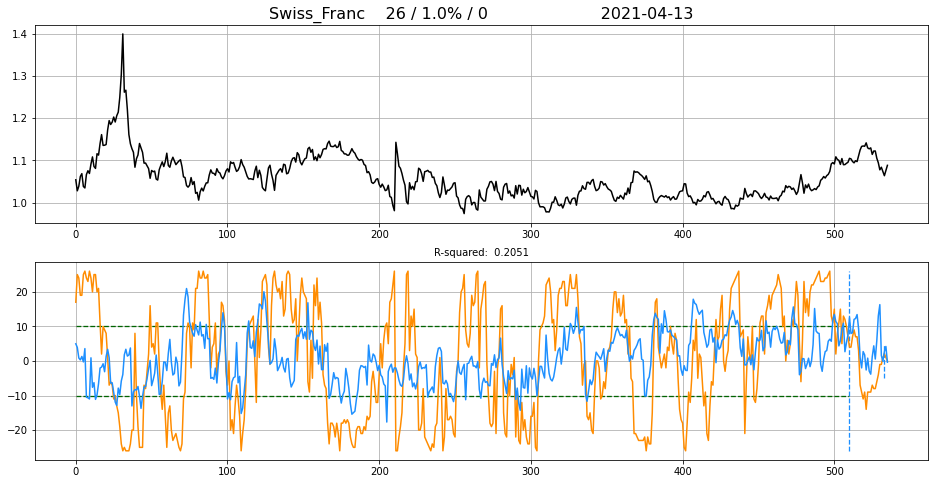

In [54]:
fig = plt.figure()
ax_1 = fig.add_subplot(2, 1, 1)
ax_1.grid()
ax_2 = fig.add_subplot(2, 1, 2)
ax_2.grid()

ax_1.set_title(prices.name+'    '+prices.descrip+'                      '+str(np.array(dates.iloc[-1:, 0:1].astype(object))[0][0])[:10], fontsize = 16)
ax_1.plot(price_close, color='black')

ax_2.set_title('R-squared:  '+str(round(r2_bin, 4)), fontsize = 10)
ax_2.plot(real_bin, color='darkorange')
ax_2.plot(forecast_bin, color='dodgerblue')

plt.hlines(10, 0, len(dates)-number_future_weeks, color = 'darkgreen', linewidth = 1.3, linestyle = '--')
plt.hlines(-10, 0, len(dates)-number_future_weeks, color = 'darkgreen', linewidth = 1.3, linestyle = '--')
# plt.hlines(5, 0, len(dates)-number_future_weeks, color = 'darkred', linewidth = 1.3, linestyle = '--')
# plt.hlines(-5, 0, len(dates)-number_future_weeks, color = 'darkred', linewidth = 1.3, linestyle = '--')

plt.vlines(len(dates)-number_future_weeks, -number_future_weeks, number_future_weeks, color = 'dodgerblue', linewidth = 1.3, linestyle = '--')
plt.vlines(len(dates)-3, -5, 5, color = 'dodgerblue', linewidth = 1.3, linestyle = '--')

fig.set_figwidth(16)
fig.set_figheight(8)
fig.show()

### Прогнозные LONG-SHORT

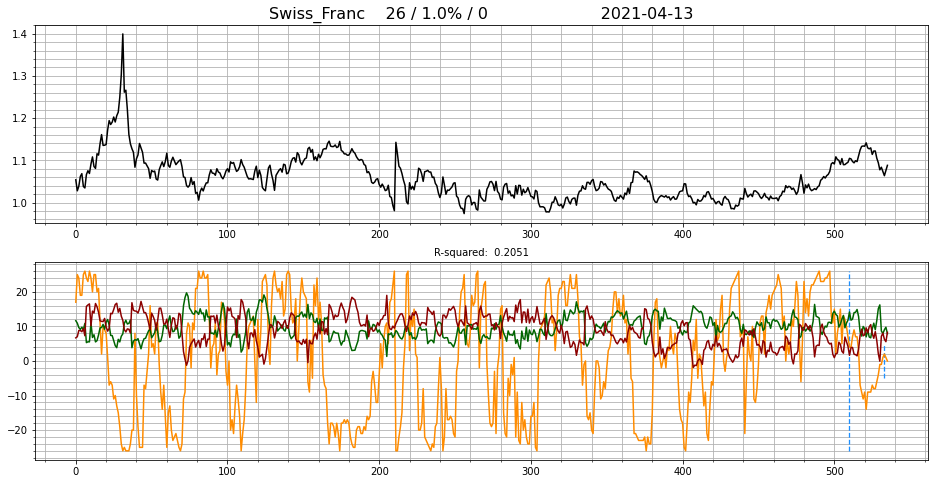

In [55]:
fig = plt.figure()
ax_1 = fig.add_subplot(2, 1, 1)
ax_1.grid(which='both')
ax_1.minorticks_on()
ax_2 = fig.add_subplot(2, 1, 2)
ax_2.grid(which='both')
ax_2.minorticks_on()

ax_1.set_title(prices.name+'    '+prices.descrip+'                      '+str(np.array(dates.iloc[-1:, 0:1].astype(object))[0][0])[:10], fontsize = 16)
ax_1.plot(price_close, color='black')

ax_2.set_title('R-squared:  '+str(round(r2_bin, 4)), fontsize = 10)
ax_2.plot(real_bin, color='darkorange')
ax_2.plot(forecast_bil, color='darkgreen')
ax_2.plot(forecast_bis, color='darkred')

# ax_2.plot(forecast_bin, color='dodgerblue')

plt.vlines(len(dates)-number_future_weeks, -number_future_weeks, number_future_weeks, color = 'dodgerblue', linewidth = 1.3, linestyle = '--')
plt.vlines(len(dates)-3, -5, 5, color = 'dodgerblue', linewidth = 1.3, linestyle = '--')

fig.set_figwidth(16)
fig.set_figheight(8)
fig.show()

### Прогнозные LONG-SHORT (крайние)

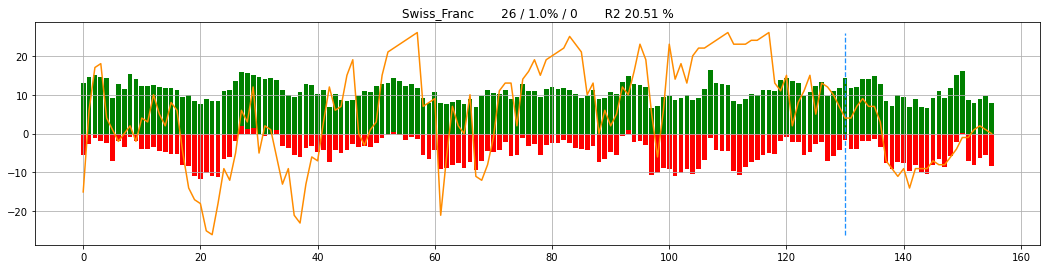

In [56]:
fig = plt.figure()

# ax_1 = fig.add_subplot(2, 1, 1)
# ax_1.grid(which='both')
ax_2 = fig.add_subplot(2, 1, 2)
ax_2.grid(which='both')

# ax_1.plot(price_low_last, color='darkred')
# ax_1.plot(price_high_last, color='darkgreen')
ax_2.bar(last_range, forecast_bil2_last, color='green')
ax_2.bar(last_range, forecast_bis2_last, color='red')
ax_2.plot(real_bin_last, color='darkorange')
# ax_1.set_title(prices.name+'       '+prices.descrip+'       '+str(np.array(dates.iloc[-1:, 0:1].astype(object))[0][0])[:10])
# ax_2.set_title('R2 '+str(round(r2_bin*100, 2))+' %', fontsize = 10)

ax_2.set_title(prices.name+'       '+prices.descrip+'       '+'R2 '+str(round(r2_bin*100, 2))+' %')

plt.vlines(last_weeks-number_future_weeks, -number_future_weeks, number_future_weeks, color = 'dodgerblue', linewidth = 1.3, linestyle = '--')

fig.set_figwidth(18)
fig.set_figheight(9)
fig.show()

# Бэктест


In [57]:
def info(array):
    print('| amount:  {}'.format(str(count_nonzero(array))[:5]))
    print('| max:     {}'.format(str(np.max(array))[:5]))
    print('| mean:    {}'.format(str(np.mean(array))[:5]))
    print('| median:  {}'.format(str(np.median(array))[:5]))
    print('| min:     {}'.format(str(np.min(array))[:5]))
    print('| st dev:  {}'.format(str(np.std(array))[:5]))

def count_nonzero(array):
    qwerty = 0
    for i in range(len(array)):
        if array[i] > 0: qwerty +=1
        else: continue
    return qwerty

## Сетка ордеров (def)

In [58]:
# TakeProfit
price_TP_long = prices.close_price()*(1+desired_price)
price_TP_short = prices.close_price()*(1-desired_price)

In [59]:
# Расчет всех возможных сроков окупаемости

payback_long = np.where(np.arange(0, len(price_TP_long), 1) != 0, 0,0)
for i in range(len(price_TP_long)):
    for q in range(len(price_close)):
        if q <= i: continue
        if price_close[q] >= price_TP_long[i]:
            payback_long[i] = (q-i)
            break
        else: payback_long[i] = 0

payback_short = np.where(np.arange(0, len(price_TP_short), 1) != 0, 0,0)
for i in range(len(price_TP_short)):
    for q in range(len(price_close)):
        if q <= i: continue
        if price_close[q] <= price_TP_short[i]:
            payback_short[i] = (q-i)
            break
        else: payback_short[i] = 0

In [60]:
# Сетка ордеров, в зависимости от уровня доверия

bil_order_list = []
for i in range(len(forecast_bil2)):
    if forecast_bil2[i] >= trust_level:
        bil_order_list.append(forecast_bil2[i])
    else:
        bil_order_list.append(0)
bis_order_list = []
for i in range(len(forecast_bis2)):
    if forecast_bis2[i] <= -trust_level:
        bis_order_list.append(forecast_bis2[i])
    else:
        bis_order_list.append(0)

bin_order_list = []
for i in range(len(forecast_bin2)):
    if forecast_bin2[i] >= trust_level:
        bin_order_list.append(forecast_bin2[i])
    elif forecast_bin2[i] <= -trust_level:
        bin_order_list.append(forecast_bin2[i])
    else:
        bin_order_list.append(0)

In [61]:
# Объединение сетки ордеров со сроками окупаемости

bil_order_list2 = copy.copy(bil_order_list)
bis_order_list2 = copy.copy(bis_order_list)
bin_order_list2 = copy.copy(bin_order_list)

for i in range(len(bil_order_list2)):
    if bil_order_list2[i] != 0:
        bil_order_list2[i] = payback_long[i]
        
for i in range(len(bis_order_list2)):
    if bis_order_list2[i] != 0:
        bis_order_list2[i] = payback_short[i]

for i in range(len(bin_order_list2)):
    if bin_order_list2[i] > 0:
        bin_order_list2[i] = payback_long[i]
    elif bin_order_list2[i] < 0:
        bin_order_list2[i] = -payback_short[i]

## Сетка ордеров (cycle)

In [70]:
pb_long_mean = []
pb_long_stdev = []
pb_long_count = []

pb_short_mean = []
pb_short_stdev = []
pb_short_count = []

pb_net_mean = []
pb_net_stdev = []
pb_net_count = []

pb_long_ok = []
pb_short_ok = []
pb_net_ok = []

for t in range(len(trust_level_range)):
    CYC_trust_level = trust_level_range[t]

    lmean = []
    lstdev = []
    lcount = []
    l_ok = []
    smean = []
    sstdev = []
    scount = []
    s_ok = []
    nmean = []
    nstdev = []
    ncount = []
    n_ok = []

    for d in range(len(desired_price_range)):
        CYC_desired_price = desired_price_range[d]

        # TakeProfit
        CYC_price_TP_long = prices.close_price()*(1+CYC_desired_price)
        CYC_price_TP_short = prices.close_price()*(1-CYC_desired_price)

        # Расчет всех возможных сроков окупаемости
        CYC_payback_long = np.where(np.arange(0, len(CYC_price_TP_long), 1) != 0, 0,0)
        for i in range(len(CYC_price_TP_long)):
            for q in range(len(price_close)):
                if q <= i: continue
                if price_close[q] >= CYC_price_TP_long[i]:
                    CYC_payback_long[i] = (q-i)
                    break
                else: CYC_payback_long[i] = 0

        CYC_payback_short = np.where(np.arange(0, len(CYC_price_TP_short), 1) != 0, 0,0)
        for i in range(len(CYC_price_TP_short)):
            for q in range(len(price_close)):
                if q <= i: continue
                if price_close[q] <= CYC_price_TP_short[i]:
                    CYC_payback_short[i] = (q-i)
                    break
                else: CYC_payback_short[i] = 0

        # Сетка ордеров, в зависимости от уровня доверия
        CYC_bil_order_list = []
        for i in range(len(forecast_bil2)):
            if forecast_bil2[i] >= CYC_trust_level:
                CYC_bil_order_list.append(forecast_bil2[i])
            else:
                CYC_bil_order_list.append(0)
        CYC_bis_order_list = []
        for i in range(len(forecast_bis2)):
            if forecast_bis2[i] <= -CYC_trust_level:
                CYC_bis_order_list.append(forecast_bis2[i])
            else:
                CYC_bis_order_list.append(0)

        CYC_bin_order_list = []
        for i in range(len(forecast_bin2)):
            if forecast_bin2[i] >= CYC_trust_level:
                CYC_bin_order_list.append(forecast_bin2[i])
            elif forecast_bin2[i] <= -CYC_trust_level:
                CYC_bin_order_list.append(forecast_bin2[i])
            else:
                CYC_bin_order_list.append(0)

        # Объединение сетки ордеров со сроками окупаемости
        CYC_bil_order_list2 = copy.copy(CYC_bil_order_list)
        CYC_bis_order_list2 = copy.copy(CYC_bis_order_list)
        CYC_bin_order_list2 = copy.copy(CYC_bin_order_list)

        for i in range(len(CYC_bil_order_list2)):
            if CYC_bil_order_list2[i] != 0:
                CYC_bil_order_list2[i] = CYC_payback_long[i]
                
        for i in range(len(CYC_bis_order_list2)):
            if CYC_bis_order_list2[i] != 0:
                CYC_bis_order_list2[i] = CYC_payback_short[i]

        for i in range(len(CYC_bin_order_list2)):
            if CYC_bin_order_list2[i] > 0:
                CYC_bin_order_list2[i] = CYC_payback_long[i]
            elif CYC_bin_order_list2[i] < 0:
                CYC_bin_order_list2[i] = -CYC_payback_short[i]

        lmean.append(np.mean(CYC_bil_order_list2))
        lstdev.append(np.std(CYC_bil_order_list2))
        lcount.append(count_nonzero(CYC_bil_order_list2))
        smean.append(np.mean(CYC_bis_order_list2))
        sstdev.append(np.std(CYC_bis_order_list2))
        scount.append(count_nonzero(CYC_bis_order_list2))
        nmean.append(np.mean(CYC_bin_order_list2))
        nstdev.append(np.std(CYC_bin_order_list2))
        ncount.append(count_nonzero(CYC_bin_order_list2))

        l_ok.append(np.mean(CYC_bil_order_list2) + np.std(CYC_bil_order_list2))
        s_ok.append(np.mean(CYC_bis_order_list2) + np.std(CYC_bis_order_list2))
        n_ok.append(np.mean(CYC_bin_order_list2) + np.std(CYC_bin_order_list2))

    pb_long_mean.append(np.array(lmean).tolist())
    pb_long_stdev.append(np.array(lstdev).tolist())
    pb_long_count.append(np.array(lcount).tolist())
    pb_long_ok.append(np.array(l_ok).tolist())

    pb_short_mean.append(np.array(smean).tolist())
    pb_short_stdev.append(np.array(sstdev).tolist())
    pb_short_count.append(np.array(scount).tolist())
    pb_short_ok.append(np.array(s_ok).tolist())

    pb_net_mean.append(np.array(nmean).tolist())
    pb_net_stdev.append(np.array(nstdev).tolist())
    pb_net_count.append(np.array(ncount).tolist())
    pb_net_ok.append(np.array(n_ok).tolist())

In [97]:
pb_long_mean = pd.DataFrame(pb_long_mean, columns=desired_price_range)
pb_long_stdev = pd.DataFrame(pb_long_stdev, columns=desired_price_range)
pb_long_count = pd.DataFrame(pb_long_count, columns=desired_price_range)
pb_long_ok = pd.DataFrame(pb_long_ok, columns=desired_price_range)

pb_short_mean = pd.DataFrame(pb_short_mean, columns=desired_price_range)
pb_short_stdev = pd.DataFrame(pb_short_stdev, columns=desired_price_range)
pb_short_count = pd.DataFrame(pb_short_count, columns=desired_price_range)
pb_short_ok = pd.DataFrame(pb_short_ok, columns=desired_price_range)

pb_net_mean = pd.DataFrame(pb_net_mean, columns=desired_price_range)
pb_net_stdev = pd.DataFrame(pb_net_stdev, columns=desired_price_range)
pb_net_count = pd.DataFrame(pb_net_count, columns=desired_price_range)
pb_net_ok = pd.DataFrame(pb_net_ok, columns=desired_price_range)

In [107]:
pd.concat([pb_long_mean, pb_long_stdev, pb_long_ok, pb_long_count], axis=1).to_csv()

',0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002,0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002,0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002,0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002\n0,13.453358208955224,15.791044776119403,16.279850746268657,18.03358208955224,19.14179104477612,20.996268656716417,22.55597014925373,23.625,25.279850746268657,38.84015352744973,43.017104308490445,43.06706897187768,44.81665376099396,45.20994194337681,47.15238065042369,49.096393172678916,49.99656004957786,50.56343035762073,52.29351173640495,58.80814908460985,59.34691971814634,62.8502358505462,64.35173298815293,68.1486493071401,71.65236332193265,73.62156004957785,75.84328110388938,521,519,515,510,508,504,500,496,491\n1,13.451492537313433,15.789179104477611,16.277985074626866,18.03171641791045,19.13992537313433,20.98507462686567,22.544776119402986,23.613805970149254,25.26865671641791,38.84077568717298,43.017767442581686,

In [108]:
pd.concat([pb_short_mean, pb_short_stdev, pb_short_ok, pb_short_count], axis=1).to_csv()

',0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002,0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002,0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002,0.002,0.004,0.006,0.008,0.01,0.012,0.014,0.016,0.018000000000000002\n0,6.8190298507462686,7.981343283582089,9.07089552238806,10.376865671641792,10.807835820895523,11.274253731343284,12.576492537313433,13.486940298507463,14.345149253731343,15.982117215832247,16.836007378955554,17.87890996638496,19.635003065950013,19.445254528407126,19.357337144058704,21.016645135994764,22.071115916564025,23.17008603605135,22.801147066578515,24.817350662537642,26.94980548877302,30.011868737591804,30.25309034930265,30.63159087540199,33.5931376733082,35.55805621507149,37.515235289782694,491,483,475,468,456,452,441,437,427\n1,6.414179104477612,7.567164179104478,8.565298507462687,9.652985074626866,10.257462686567164,10.662313432835822,11.966417910447761,12.914179104477611,13.85820895522388,15.4074059192958

## Визуализация

### Все возможные сроки окупаемости (крайние значения)

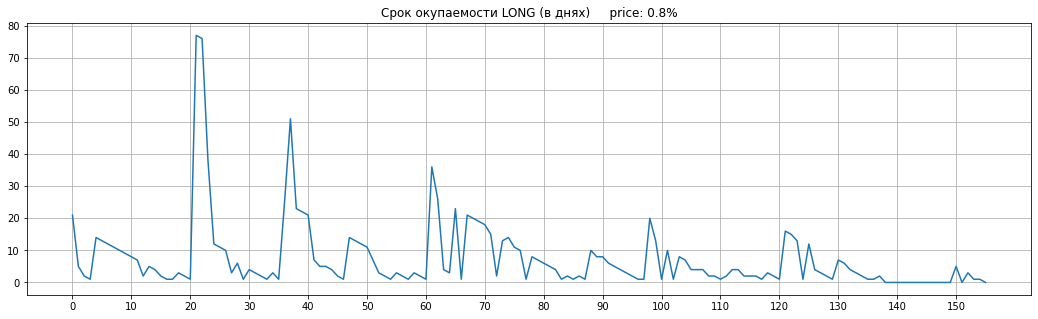

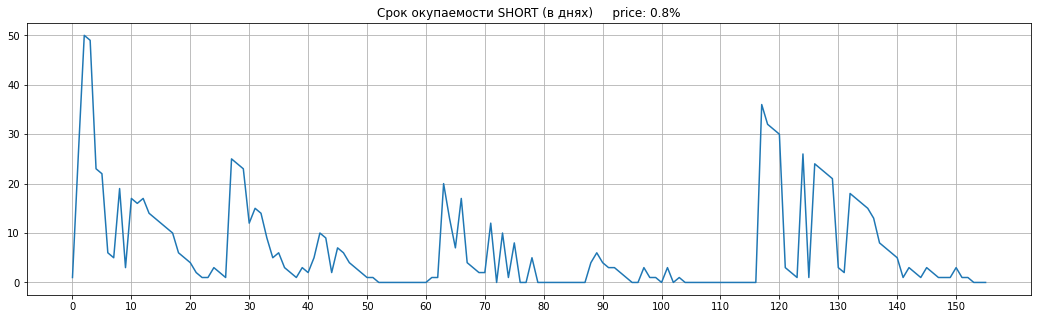

In [72]:
plt.figure(figsize=(18,5))
plt.title('Срок окупаемости LONG (в днях)     price: ' + str(desired_price*100)+'%')
plt.xticks(last_range_10)
plt.grid()

plt.plot(payback_long[len(payback_long)- last_weeks : len(payback_long)])

plt.show()
plt.figure(figsize=(18,5))
plt.title('Срок окупаемости SHORT (в днях)     price: ' + str(desired_price*100)+'%')
plt.xticks(last_range_10)
plt.grid()

plt.plot(payback_short[len(payback_short)- last_weeks : len(payback_short)])

plt.show()

### Сетка ордеров NET

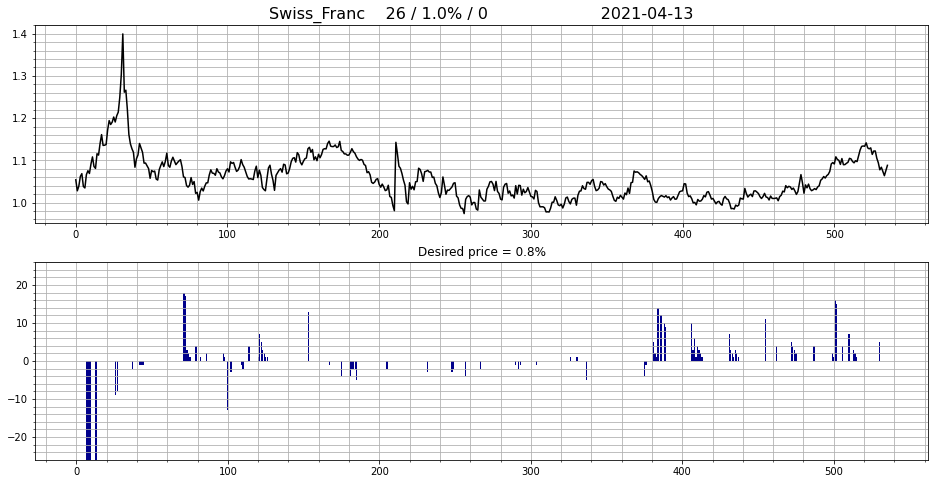

In [73]:
fig = plt.figure()    
ax_1 = fig.add_subplot(2, 1, 1)
ax_1.grid(which='both')
ax_1.minorticks_on()
ax_2 = fig.add_subplot(2, 1, 2)
ax_2.grid(which='both')
ax_2.minorticks_on()

ax_2.set_ylim(-26, 26)

ax_1.set_title(prices.name+'    '+prices.descrip+'                      '+str(np.array(dates.iloc[-1:, 0:1].astype(object))[0][0])[:10], fontsize = 16)
ax_1.plot(price_close, color='black')

ax_2.set_title('Desired price = {}%'.format(str(desired_price*100)))
ax_2.bar(all_range, bin_order_list2, color='darkblue')

fig.set_figwidth(16)
fig.set_figheight(8)
fig.show()

### Сетка ордеров LONG-SHORT

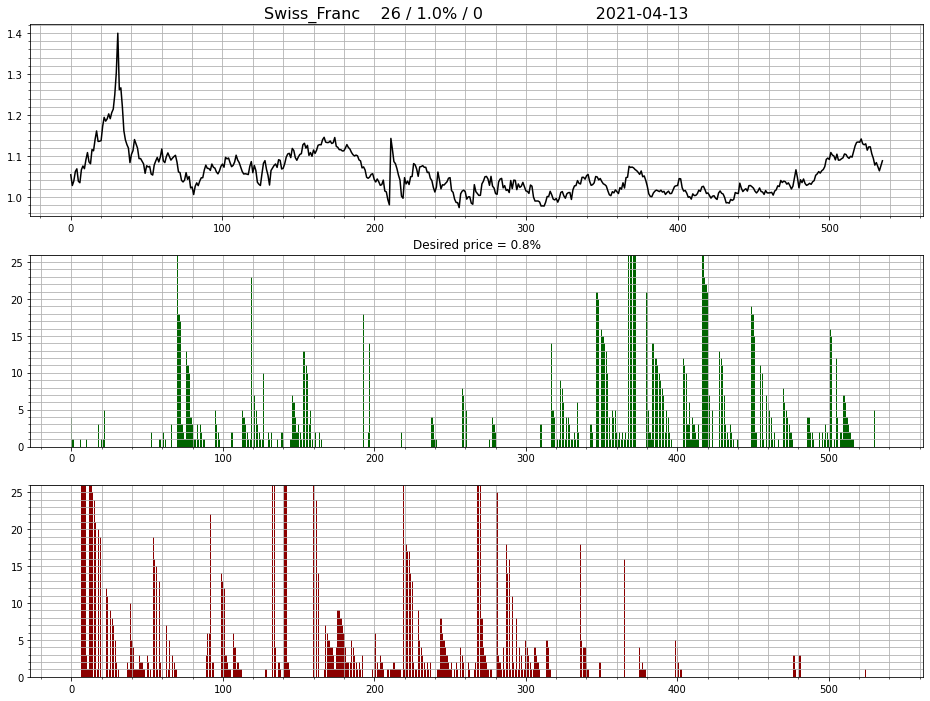

In [74]:
fig = plt.figure()
# axxx = np.arange(0,len(bil))
               
ax_1 = fig.add_subplot(3, 1, 1)
ax_1.grid(which='both')
ax_1.minorticks_on()
ax_2 = fig.add_subplot(3, 1, 2)
ax_2.grid(which='both')
ax_2.minorticks_on()
ax_3 = fig.add_subplot(3, 1, 3)
ax_3.grid(which='both')
ax_3.minorticks_on()

ax_2.set_ylim(0, 26)
ax_3.set_ylim(0, 26)

ax_1.set_title(prices.name+'    '+prices.descrip+'                      '+str(np.array(dates.iloc[-1:, 0:1].astype(object))[0][0])[:10], fontsize = 16)
ax_1.plot(price_close, color='black')

ax_2.set_title('Desired price = {}%'.format(str(desired_price*100)))
ax_2.bar(all_range, bil_order_list2, color='darkgreen')
ax_3.bar(all_range, bis_order_list2, color='darkred')

fig.set_figwidth(16)
fig.set_figheight(12)
fig.show()

In [75]:
bil_order_list2 = pd.DataFrame(bil_order_list2, columns=['bil_order_list']).replace(0, np.NaN)
bis_order_list2 = pd.DataFrame(bis_order_list2, columns=['bis_order_list']).replace(0, np.NaN)

In [76]:
print('Longs')
print(info(bil_order_list2['bil_order_list']), end='\n\n')
print('Shorts')
print(info(bis_order_list2['bis_order_list']))

Longs
| amount:  230
| max:     130.0
| mean:    8.104
| median:  nan
| min:     1.0
| st dev:  18.92
None

Shorts
| amount:  229
| max:     62.0
| mean:    6.947
| median:  nan
| min:     1.0
| st dev:  10.67
None


### Распределение ордеров в зависимости от сроков окупаемости

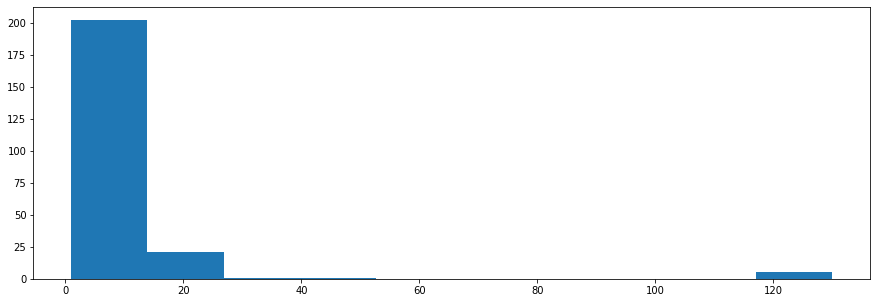

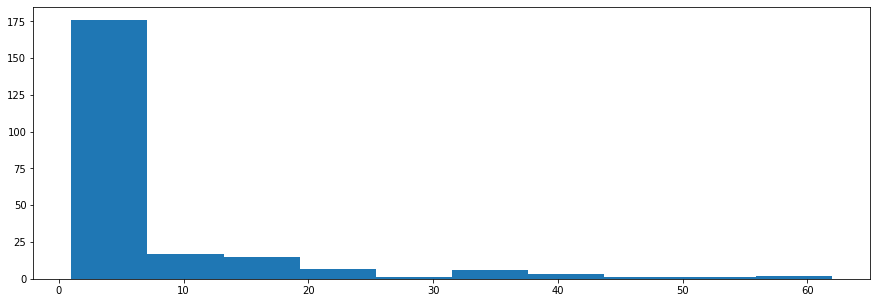

In [77]:
plt.figure(figsize=(15,5))
plt.hist(bil_order_list2['bil_order_list'])
plt.show()
plt.figure(figsize=(15,5))
plt.hist(bis_order_list2['bis_order_list'])
plt.show()

## Выгрузка статистики

In [78]:
pd.DataFrame(forecast_bil2, columns=['fbil']).to_csv(index=False)

'fbil\n11.652301772130153\n10.943077408396903\n9.672695353953163\n9.125866112948627\n9.771828723001676\n9.077753765254437\n10.868843281879794\n5.3051076370452055\n5.545085703044704\n5.529664627139219\n11.068462239464871\n6.796876866860726\n7.590922740180387\n5.5109117465480235\n5.88837372699381\n7.532639456219748\n9.56827673780398\n9.678139991336174\n10.586040378604645\n9.192912215952013\n11.1911984102356\n12.001458840667642\n10.41095762845287\n7.393544820389288\n7.348522644823379\n5.855384786877517\n4.43085000942013\n3.845650607268192\n6.257860846411116\n5.5108132930718385\n7.156794317813747\n7.840436132265788\n10.850931682571431\n11.779427882611255\n10.691837473855031\n10.893555001308773\n11.858784091862193\n3.8356523309638817\n5.727279695427344\n6.164552631444051\n5.999092238546693\n6.468356031601827\n4.971240217278425\n3.520847106485808\n5.306291515675888\n6.434856879853447\n6.571613703539531\n7.716542500282481\n8.732171161387841\n9.19739155251493\n6.712518989886885\n7.393396429234

In [79]:
pd.DataFrame(forecast_bis2, columns=['fbis']).to_csv(index=False)

'fbis\n-6.688362161880633\n-7.020638645443036\n-8.811314665634413\n-8.822174636340659\n-8.463058044904038\n-9.345347128872483\n-7.292337394199542\n-15.78757557746578\n-16.2043369352738\n-16.51862646252051\n-10.15653940441277\n-14.416669845794596\n-13.86067051242977\n-16.62812685915038\n-15.699365916414262\n-14.117548616499088\n-11.616222268250041\n-11.457277398886227\n-11.398368481384171\n-12.308000548425829\n-9.90435037562855\n-8.627978055854213\n-9.434683058064428\n-13.787951779190294\n-13.66094546409132\n-14.903034493229196\n-16.32246045878288\n-16.708472924148545\n-14.106955975447354\n-15.217658343981679\n-12.961391909344751\n-11.778443371543633\n-9.07641927863329\n-8.395549016907088\n-9.283455049335199\n-9.16519768456732\n-8.099699055696584\n-16.85470194090953\n-14.67239305553829\n-14.45255985367722\n-14.396900881352394\n-13.859920522210246\n-15.110680585770783\n-17.240083977109293\n-15.586822761015537\n-13.938665909311483\n-13.998300070219626\n-12.798890032579063\n-11.00032013063

In [80]:
pd.DataFrame(payback_long, columns=['lpb']).to_csv(index=False)

'lpb\n4\n1\n1\n5\n6\n2\n1\n1\n2\n1\n1\n5\n2\n1\n2\n1\n1\n4\n3\n2\n1\n1\n5\n2\n1\n3\n1\n2\n1\n1\n1\n0\n0\n0\n0\n0\n0\n5\n4\n1\n1\n1\n0\n123\n110\n15\n14\n10\n9\n1\n6\n5\n4\n2\n1\n1\n3\n3\n1\n1\n93\n2\n1\n1\n82\n81\n3\n76\n78\n77\n32\n18\n17\n3\n2\n1\n13\n11\n10\n4\n3\n1\n1\n3\n1\n3\n2\n1\n1\n13\n3\n2\n1\n9\n8\n5\n3\n2\n1\n3\n2\n1\n42\n6\n39\n4\n2\n2\n1\n37\n33\n31\n7\n5\n4\n3\n2\n1\n1\n23\n1\n7\n5\n3\n2\n1\n1\n10\n15\n5\n2\n1\n2\n2\n3\n2\n1\n6\n5\n2\n1\n1\n2\n3\n2\n1\n7\n6\n4\n2\n3\n2\n1\n13\n13\n11\n10\n3\n5\n1\n3\n2\n1\n3\n2\n1\n0\n0\n6\n5\n4\n0\n2\n1\n0\n36\n35\n5\n4\n3\n2\n30\n29\n28\n27\n26\n25\n24\n23\n22\n21\n20\n19\n18\n17\n4\n2\n14\n13\n12\n11\n10\n9\n8\n2\n1\n5\n4\n3\n2\n1\n0\n306\n288\n284\n11\n10\n8\n2\n1\n6\n3\n2\n1\n2\n1\n272\n271\n270\n1\n268\n267\n266\n265\n264\n133\n132\n5\n4\n3\n1\n1\n126\n31\n1\n4\n3\n2\n1\n92\n118\n15\n14\n4\n3\n2\n1\n2\n8\n7\n6\n5\n4\n3\n2\n1\n6\n4\n3\n2\n1\n2\n1\n95\n94\n66\n1\n91\n4\n3\n2\n1\n2\n58\n57\n5\n4\n3\n2\n1\n50\n1\n48\n47\n1\n42\n2\n1\n3

In [81]:
pd.DataFrame(payback_short, columns=['spb']).to_csv(index=False)

'spb\n1\n80\n77\n2\n1\n74\n73\n42\n41\n40\n3\n1\n37\n36\n25\n24\n21\n1\n20\n19\n17\n14\n13\n12\n11\n1\n9\n8\n7\n5\n2\n1\n2\n1\n1\n1\n1\n2\n1\n10\n5\n4\n1\n1\n1\n3\n2\n2\n1\n24\n3\n2\n1\n20\n19\n16\n15\n1\n13\n2\n1\n10\n9\n7\n1\n5\n5\n3\n2\n1\n1\n2\n1\n6\n5\n4\n1\n2\n1\n2\n1\n128\n125\n124\n123\n40\n37\n36\n9\n3\n6\n6\n22\n2\n2\n1\n27\n26\n19\n14\n13\n12\n3\n2\n1\n1\n7\n6\n4\n1\n2\n1\n1\n10\n9\n8\n7\n6\n2\n1\n3\n1\n1\n84\n83\n82\n5\n2\n1\n1\n1\n76\n63\n62\n60\n4\n59\n2\n1\n56\n55\n51\n49\n2\n1\n47\n2\n1\n44\n43\n41\n39\n38\n4\n1\n2\n1\n33\n1\n31\n26\n29\n24\n14\n13\n12\n6\n1\n7\n6\n5\n4\n4\n3\n1\n4\n9\n9\n8\n7\n6\n4\n2\n2\n2\n5\n4\n3\n2\n1\n2\n1\n3\n2\n1\n6\n5\n4\n2\n1\n4\n6\n2\n1\n3\n2\n1\n2\n1\n1\n0\n1\n1\n2\n1\n1\n1\n1\n36\n35\n1\n18\n17\n17\n14\n13\n2\n1\n1\n9\n5\n4\n3\n2\n1\n2\n1\n2\n1\n1\n13\n10\n1\n1\n8\n6\n5\n4\n3\n2\n1\n2\n1\n1\n2\n1\n0\n4\n3\n2\n1\n3\n2\n1\n0\n0\n1\n2\n37\n37\n36\n8\n4\n3\n2\n1\n4\n1\n2\n1\n25\n25\n3\n2\n1\n4\n1\n18\n14\n16\n1\n11\n2\n1\n8\n1\n4\n3\n1\n1\n5\n4